In [1]:
import os
import json
import pandas as pd
import numpy as np
import scipy as sp
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

# Metrics obtained from an organizer of the Challenge
# https://github.com/plamere/RecsysChallengeTools/blob/master/metrics.py
from metrics import r_precision
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
playlists = list()
tracks = dict()
map_pl = list()

max_files_for_quick_processing = 1


def process_track(track):
    key = track['track_uri']
    if not key in tracks:
        tk = dict()
        tk['track_artist_name'] = track['artist_name']
        tk['track_artist_uri'] = track['artist_uri']
        tk['track_name'] = track['track_name']
        tk['track_album_uri'] = track['album_uri']
        tk['track_duration_ms'] = track['duration_ms']
        tk['track_album_name'] = track['album_name']
        tracks[track['track_uri']] = tk
    return key


def process_playlist(playlist):
    pl = dict()
    pl['playlist_name'] = playlist['name']
    pl['playlist_collaborative'] = playlist['collaborative']
    pl['playlist_pid'] = playlist['pid']
    pl['playlist_modified_at'] = playlist['modified_at']
    pl['playlist_num_albums'] = playlist['num_albums']
    pl['playlist_num_tracks'] = playlist['num_tracks']
    pl['playlist_num_followers'] = playlist['num_followers']
    pl['playlist_num_edits'] = playlist['num_edits']
    pl['playlist_duration_ms'] = playlist['duration_ms']
    pl['playlist_num_artists'] = playlist['num_artists']
    if 'description' in playlist:
        pl['playlist_description'] = playlist['description']
    else:
        pl['playlist_description'] = ''
    trks = list()
    for track in playlist['tracks']:
        map_pl.append([playlist['pid'], track['track_uri']])
        trks.append(track['track_uri'])
        process_track(track)
    return pl

def process_mpd(path):
    count = 0
    filenames = os.listdir(path)
    for filename in sorted(filenames):
        print(filename)
        if filename.startswith("mpd.slice.") and filename.endswith(".json"):
            fullpath = os.sep.join((path, filename))
            f = open(fullpath)
            js = f.read()
            f.close()
            slice = json.loads(js)
            for playlist in slice['playlists']:
                playlists.append(process_playlist(playlist))
            count += 1
            if quick and count > max_files_for_quick_processing:
                break

quick = True
process_mpd('mpd.v1/data')

mpd.slice.0-999.json
mpd.slice.1000-1999.json


In [3]:
print(len(playlists))
print(len(tracks))
print(len(map_pl))

2000
57884
134125


In [4]:
playlist_df = pd.DataFrame(playlists)
playlist_df.head()
# print(playlist_df.describe())

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid
0,false,,11532414,1493424000,Throwbacks,47,37,6,1,52,0
1,false,,11656470,1506556800,Awesome Playlist,23,21,5,1,39,1
2,false,,14039958,1505692800,korean,51,31,18,1,64,2
3,false,,28926058,1501027200,mat,107,86,4,1,126,3
4,false,,4335282,1401667200,90s,16,16,7,2,17,4


In [5]:
tracks_df = pd.DataFrame.from_dict(tracks, orient='index')
tracks_df.head()
# print(tracks_df.describe())

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name
spotify:track:000mA0etY38nKdvf1N04af,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way
spotify:track:000xQL6tZNLJzIrtIgxqSl,ZAYN,spotify:artist:5ZsFI1h6hIdQRw2ti0hz81,Still Got Time,spotify:album:2kGUeTGnkLOYlinKRJe47G,188490,Still Got Time
spotify:track:002PgfoyfrOGiKch4EW8Wm,Alan Menken,spotify:artist:5sy77gt4bfsLcSQ8GIe4ZZ,Jasmine Runs Away,spotify:album:29EiOQJnxWlX5nVOWQpu3u,46866,Aladdin
spotify:track:004skCQeDn1iLntSom0rRr,Kevin Jonas,spotify:artist:11bdWrCwHE2gCdVARdASuu,Heart and Soul,spotify:album:5iK842b9xnZblgZkRxWCFe,177773,Camp Rock 2: The Final Jam
spotify:track:005CGalYNgMNZcvWMIFeK8,Nelson Y Sus Estrellas,spotify:artist:5SRwYMyavJCNT2AdVMpPgi,LLorándote,spotify:album:2TfoLoZHhsL0oAYBxDi4t2,321480,Orquídea de Plata


In [6]:
playlist_map_df = pd.DataFrame(map_pl, columns=['playlist_pid', 'track_uri'])
playlist_map_df.head()
#print(playlist_map_df.describe())

,playlist_pid,track_uri
0,0,spotify:track:0UaMYEvWZi0ZqiDOoHU3YI
1,0,spotify:track:6I9VzXrHxO9rA9A5euc8Ak
2,0,spotify:track:0WqIKmW4BTrj3eJFmnCKMv
3,0,spotify:track:1AWQoqb9bSvzTjaLralEkT
4,0,spotify:track:1lzr43nnXAijIGYnCT8M8H


We set strings to lower case remove all non alphabetic characters and stop-words

In [7]:
import nltk
import string
#nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

playlist_df.playlist_description = playlist_df.playlist_description.apply(lambda x: x.lower())
playlist_df.playlist_description = playlist_df.playlist_description.str.replace('[^a-z]+', ' ')
playlist_df.playlist_description = playlist_df.playlist_description.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: x.lower())
playlist_df.playlist_name = playlist_df.playlist_name.str.replace('[^a-z]+', ' ')
playlist_df.playlist_name = playlist_df.playlist_name.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

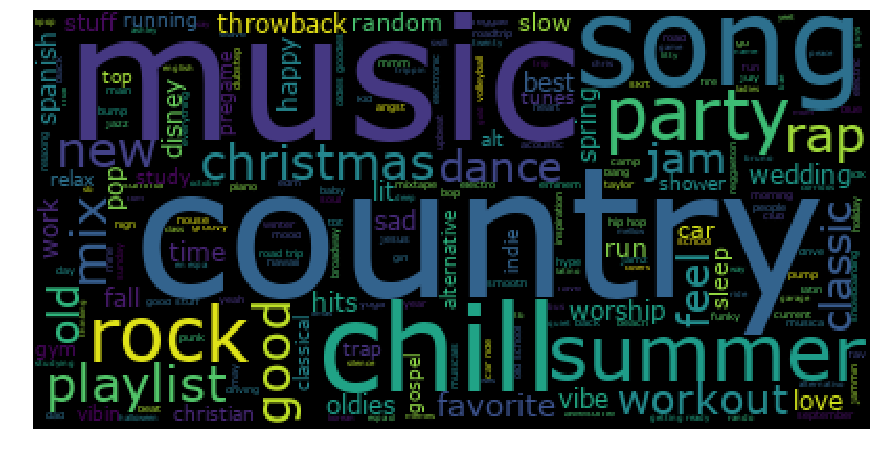

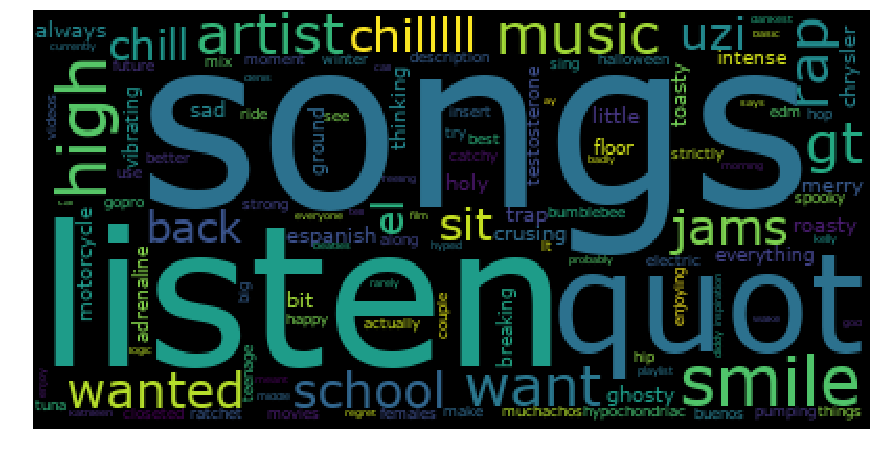

In [74]:
#from PIL import Image
#pip install wordcloud
from wordcloud import WordCloud

cv = CountVectorizer(min_df=0, stop_words=None, max_features=200)
counts = cv.fit_transform(playlist_df.playlist_name).toarray().ravel()                                                  
words = np.array(cv.get_feature_names()) 
# normalize 

def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(font_path='/Library/Fonts/Verdana.ttf',
                          relative_scaling = 0.1,
                          ).generate(text)
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()

generate_wordcloud(' '.join(playlist_df.playlist_name))

generate_wordcloud(' '.join(playlist_df.playlist_description))

In [17]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

cv_description = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_description = cv_description.fit_transform(playlist_df.playlist_description)
playlist_df['playlist_description_frequency'] = list(dt_mat_description.toarray())

cv_name = CountVectorizer(token_pattern=r"(?u)\b\w+\b", stop_words=None, ngram_range=(1,1), analyzer='word')
dt_mat_name = cv_name.fit_transform(playlist_df.playlist_name)
playlist_df['playlist_name_frequency'] = list(dt_mat_name.toarray())

In [20]:
tfidf_transformer = TfidfTransformer()

tfidf_mat_description = tfidf_transformer.fit_transform(dt_mat_description)
playlist_df['playlist_description_tfidf_score']=list(tfidf_mat_description.toarray())

tfidf_mat_name = tfidf_transformer.fit_transform(dt_mat_name)
playlist_df['playlist_name_tfidf_score']=list(tfidf_mat_name.toarray())
playlist_df

,playlist_collaborative,playlist_description,playlist_duration_ms,playlist_modified_at,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_pid,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score
0,false,,11532414,1493424000,throwbacks,47,37,6,1,52,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,false,,11656470,1506556800,awesome playlist,23,21,5,1,39,1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,false,,14039958,1505692800,korean,51,31,18,1,64,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,false,,28926058,1501027200,mat,107,86,4,1,126,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,false,,4335282,1401667200,,16,16,7,2,17,4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,false,,19156557,1430956800,wedding,71,56,3,1,80,5,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
6,false,,3408479,1477094400,put spell,15,13,2,1,16,6,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
7,false,,12674796,1509321600,,52,48,38,1,53,7,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,false,,9948921,1508976000,bop,37,23,21,2,46,8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
9,false,,4297488,1501804800,old country,20,18,10,1,21,9,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [27]:
bigrams_name_frequency = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_frequency)

bigrams_desc_frequency = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_frequency['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_frequency)

bigrams_name_tfidf_score = pd.DataFrame(dt_mat_name.todense(), index=playlist_df.index, columns=cv_name.get_feature_names())
bigrams_name_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_name_tfidf_score)

bigrams_desc_tfidf_score = pd.DataFrame(tfidf_mat_description.todense(), index=playlist_df.index, columns=cv_description.get_feature_names())
bigrams_desc_tfidf_score['playlist_pid'] = playlist_df.playlist_pid
print(bigrams_desc_tfidf_score)

      aa  aaa  abby  acoustic  adoracion  adore  adventure  af  afrikaans  \
0      0    0     0         0          0      0          0   0          0   
1      0    0     0         0          0      0          0   0          0   
2      0    0     0         0          0      0          0   0          0   
3      0    0     0         0          0      0          0   0          0   
4      0    0     0         0          0      0          0   0          0   
5      0    0     0         0          0      0          0   0          0   
6      0    0     0         0          0      0          0   0          0   
7      0    0     0         0          0      0          0   0          0   
8      0    0     0         0          0      0          0   0          0   
9      0    0     0         0          0      0          0   0          0   
10     0    0     1         0          0      0          0   0          0   
11     0    0     0         0          0      0          0   0          0   

In [10]:
merged = pd.merge(
    pd.merge(
        tracks_df, playlist_map_df, left_index=True, right_on='track_uri'),
    playlist_df,
    on='playlist_pid')

In [11]:
merged.head()

,track_artist_name,track_artist_uri,track_name,track_album_uri,track_duration_ms,track_album_name,playlist_pid,track_uri,playlist_collaborative,playlist_description,...,playlist_name,playlist_num_albums,playlist_num_artists,playlist_num_edits,playlist_num_followers,playlist_num_tracks,playlist_description_frequency,playlist_name_frequency,playlist_description_tfidf_score,playlist_name_tfidf_score
0,The Coronas,spotify:artist:2tppd6KkhK4ULAd217Ecq1,If I Gave Myself To Someone Else,spotify:album:662PiU3dRsilN0Gp87IiSF,214506,The Long Way,371,spotify:track:000mA0etY38nKdvf1N04af,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Lewis Watson,spotify:artist:40ELTAg7Kg6vbWnlyx2n9R,stones around the sun,spotify:album:4cKBAg2zgjrVF2XefrW4WC,224440,the morning,371,spotify:track:0JGbwcwPV0VfuR4zDcZ9ce,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,Jaymes Young,spotify:artist:6QrQ7OrISRYIfS5mtacaw2,We Won't,spotify:album:6MuWCR3WPjwyKhqsTKLZ3z,240586,Feel Something,371,spotify:track:0Zge2Kfo3Yd9JOGnAmVPbb,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,John Lucas,spotify:artist:7iEy8zKFtlYIINaxxLIyBk,This Will Be Our Home,spotify:album:2N7sEVVS3jKMJJuJi4v0UF,277160,Promised Land,371,spotify:track:1Sw7fhf7YJCD6GcWW0wETD,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Hozier,spotify:artist:2FXC3k01G6Gw61bmprjgqS,Cherry Wine - Live,spotify:album:36k5aXpxffjVGcNce12GLZ,240147,Hozier,371,spotify:track:1ivHxaGL5ld9VS1zsYc4YN,false,,...,quiet,15,14,4,1,15,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [12]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


KeyboardInterrupt: 

In [ ]:
# Provide labels
negative_samples['match'] = 0
merged['match'] = 1

In [ ]:
negative_samples.head()

In [ ]:
merged.head()

In [ ]:
negative_samples.head()

In [ ]:
merged.columns

In [ ]:
negative_samples.columns

In [ ]:
dataset = merged.append(negative_samples[merged.columns]).sort_values(by=['playlist_pid']).reset_index(drop=True)

In [ ]:
dataset.tail(32)

In [ ]:
# Include the features in the list below
features = [
    'playlist_duration_ms', 'playlist_num_albums', 'playlist_num_artists',
    'playlist_num_edits', 'playlist_num_followers', 'playlist_num_tracks',
    'playlist_pid', 'track_duration_ms'
]
data_x = dataset[features]
data_y = dataset.match
X_train, X_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.1, random_state=42, shuffle=True)

In [ ]:
X_test.head()

In [ ]:
y_test.head()
# y_test[y_test == 1].head()

In [ ]:
dataset.loc[X_test.head().index]

In [ ]:
y_test[y_test == 1].head()

In [ ]:
# 1. Calculate metric only on test set using the positive samples
#     a. Obtain unique playlists in the test set
#     b. For each playlist, obtain the positve songs.
#     c. Set both `target` and `prediction` as lists of the positive songs
#     d. For each playlist, calculate the r_precision. r_precision comes from the metrics.py file in the repo.

# 2. Train the X_train on the classifier. Obtain predictions for X_test

# 3. Repeat 1 above, now setting `predictions` as the list of songs "ranked by probability".

# 4. Calculate the r_precision metric based on your predicitons!

In [ ]:
# Create Negative Samples
negative_samples = pd.DataFrame([])
for pid, df in tqdm(merged.groupby(["playlist_pid"])):
    negative_tracks = tracks_df.drop(df.track_uri).sample(df.shape[0])
    negative_playlist_tracks = pd.concat(
        [
            df.drop(list(tracks_df.columns) + ['track_uri'], axis=1).reset_index(
                drop=True), negative_tracks.reset_index()
        ],
        axis=1)
    negative_playlist_tracks.rename(columns={'index': 'track_uri'}, inplace=True)
    negative_samples = negative_samples.append(negative_playlist_tracks)


In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    probs = y_test.loc[df.index]  # change y_test to the output probs from clf
    targets = dataset.loc[probs[probs == 1].index].track_uri
    predictions = dataset.loc[probs[probs > 0.5].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

In [ ]:
lr_clf = LogisticRegression()
lr_clf = lr_clf.fit(X_train, y_train)

In [ ]:
# y_prob = lr_clf.predict_proba(X_test)
y_prob = pd.DataFrame(lr_clf.predict_proba(X_test), index=y_test.index)

In [ ]:
y_prob.head(10)

In [ ]:
y_test.head()

In [ ]:
y_pred = y_prob.idxmax(axis=1)

In [ ]:
r_precisions = []
for pid, df in tqdm(X_test.groupby(["playlist_pid"])):
    labels = y_test.loc[df.index]  # change y_test to the output probs from clf
    preds = y_pred.loc[df.index]
    targets = dataset.loc[labels[labels == 1].index].track_uri
    predictions = dataset.loc[preds[preds == 1].index].track_uri.unique()
    if len(targets) > 0:
        r_precisions.append(r_precision(targets, predictions))
np.mean(r_precisions)    

Question: Do playlist and track duration interact to influence whether a song should belong to a playlist `(match=1)` or whether a song should not belong to a playlist `(match=0)`?

In [ ]:
(dataset[dataset.match==1].playlist_duration_ms/dataset[dataset.match==1].playlist_num_tracks)

In [ ]:
plt.scatter(dataset[dataset.match == 1].playlist_duration_ms /
            dataset[dataset.match == 1].playlist_num_tracks,
            dataset[dataset.match == 1].track_duration_ms)
plt.scatter(dataset[dataset.match == 0].playlist_duration_ms /
            dataset[dataset.match == 0].playlist_num_tracks,
            dataset[dataset.match == 0].track_duration_ms)
plt.xlabel('Average Track Duration')
plt.ylabel('Track Duration')


A trend which might not be that strong to notice is that as the average track duration increases for a playlist, the propensity to see a track of long duration increases. However, this isn't the case with negative sample playlists, where in playlist of short length very long tracks can still be detected.

In [ ]:
plt.hist(dataset[dataset.match==1].playlist_duration_ms)
plt.hist(dataset[dataset.match==0].playlist_duration_ms)